# Question 1: Stock price prediction using deep sequence modeling (RNN and LSTM)

Can we beat a naive forecaster using RNN or LSTM???

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import timeseries_dataset_from_array

2024-11-26 20:33:52.091517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732678433.169489  570727 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732678433.473445  570727 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 20:33:56.384449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# loading the data
df = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv', index_col=0, header=[0,1])

# setting frequency of the data
df.index.freq = 'B'
df.index = pd.to_datetime(df.index)
df = df.resample('B').ffill()

# # selecting the stock data from previous homework
df = df['Adj Close']['MSFT']
df = pd.DataFrame({'Adj Close': df})
df.head()

,Adj Close
Date,
2018-01-02,80.229012
2018-01-03,80.602394
2018-01-04,81.311806
2018-01-05,82.319908
2018-01-08,82.403923


## 1. 

Is the timeseries of your stock/ETF stationary when you plot it over time? Why or why not can you determine this by simply looking at the plot?

<Axes: xlabel='Date'>

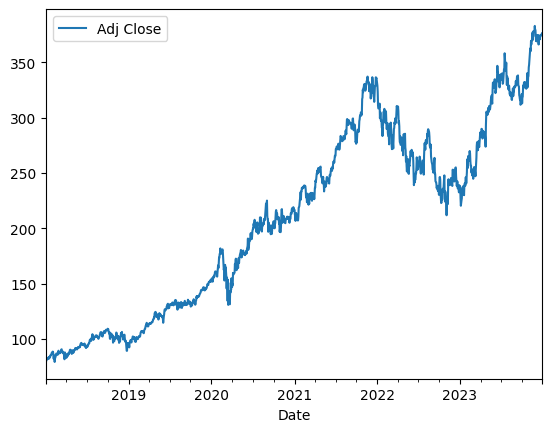

In [3]:
df.plot()

No the data is not stationary. It has an upward trend and the variance appears to be changing over time.

## 2. 

Create a new column called "LogReturn" and add it to your data frame. LogReturn = Log(P2) - Log(P1)

In [4]:
df['LogReturn'] = np.log(df['Adj Close']).diff()
df = df.dropna()

## 3. 

Plot the log returns. Are they stationary?

/tmp/ipykernel_570727/2184289232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


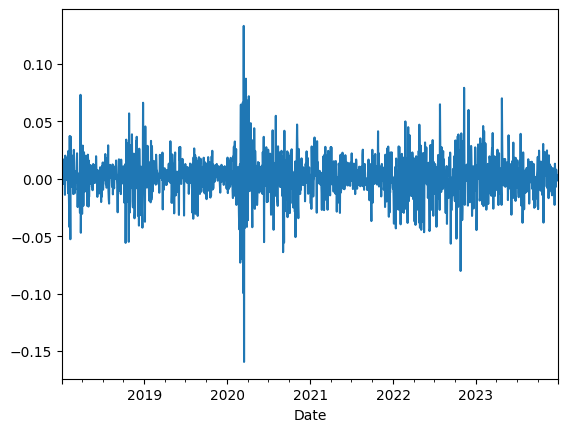

In [5]:
df['LogReturn'].plot()
df.dropna(inplace=True)

This plot appears to be stationary. The values are around 0 which appears to be the mean. The variance is pretty consistent. No trend up or down. The fluctuations appear to be random. 

## 4. 

Split your dataset into 60% train, 20% validation, and the remaining data as test.

In [6]:
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size+val_size]
test_data = df[train_size+val_size:]

## 5. 

Generate train, val, and test dataset using timeseries_dataset_from_array() utility from Keras.

- We are planning to use the past 60 days to predict the return on the next day. 
- Use batch size = 32

In [7]:
series = df['LogReturn']
sequence_length = 60 # using past 60 days to predict the next day
h = 1
delay = sequence_length + h - 1
batch_size = 32

train_dataset = timeseries_dataset_from_array(
    data = series[:-delay],
    targets = series[delay:],
    sequence_length = sequence_length,
    shuffle=False,
    batch_size = batch_size,
    start_index = 0,
    end_index = train_size
)

val_dataset = timeseries_dataset_from_array(
    data = series[:-delay],
    targets = series[delay:],
    sequence_length = sequence_length,
    shuffle=False,
    batch_size = batch_size,
    start_index = train_size,
    end_index = train_size + val_size
)

test_dataset = timeseries_dataset_from_array(
    data = series[:-delay],
    targets = series[delay:],
    sequence_length = sequence_length,
    shuffle=False,
    batch_size = batch_size,
    start_index = train_size + val_size
)

I0000 00:00:1732678525.920354  570727 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:03:00.0, compute capability: 8.9


## 6. 

Create a naive forecaster(common-sense benchmark) and report the Validation and Test mae. Our goal is to beat these metrics. 

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] # naive forecast is the last value observed in the sequence
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Train MAE: {evaluate_naive_method(train_dataset)}")
print(f"Val MAE: {evaluate_naive_method(val_dataset)}")
print(f"Test MAE: {evaluate_naive_method(test_dataset)}") 

# the unit is LogReturn

Train MAE: 0.019612712966450813
Val MAE: 0.0230741922076432
Test MAE: 0.01743314097910985


2024-11-26 20:35:28.968325: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-26 20:35:29.006266: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 7. 

Train a simple RNN model and report the Test MAE. Feel free to pick any architecture but here are some suggestions.

- 64 recurrent cells
- epochs = 20
- use callback = ModelCheckpoint
- keep track of MAE metric
- use loss='mse'

In [9]:
from tensorflow.keras import layers

In [10]:
n_features = 1

In [11]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(64, return_sequences=True)(inputs)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 60, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callbacks = [keras.callbacks.ModelCheckpoint("RNN.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/20


I0000 00:00:1732678560.992140  572468 service.cc:148] XLA service 0x7f91e0003f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732678560.992791  572468 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-26 20:36:01.259539: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732678561.518791  572468 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732678562.503089  572468 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0036 - mae: 0.0343 - val_loss: 7.1726e-04 - val_mae: 0.0210
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8459e-04 - mae: 0.0159 - val_loss: 5.8142e-04 - val_mae: 0.0190
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4965e-04 - mae: 0.0155 - val_loss: 5.0995e-04 - val_mae: 0.0177
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0568e-04 - mae: 0.0146 - val_loss: 4.7191e-04 - val_mae: 0.0170
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7902e-04 - mae: 0.0140 - val_loss: 4.4923e-04 - val_mae: 0.0165
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6069e-04 - mae: 0.0135 - val_loss: 4.3494e-04 - val_mae: 0.0162
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4800e-04 - mae: 0.0132 - val_loss: 4.2572e-04 - val_mae: 0.0160
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3879e-04 - mae: 0.0129 - val_loss: 4.1971e-04 - val_mae: 0.0159
Epoch 9/20
28/28 ━━━━

## 8. 

Using the RNN model, plot the MAE vs epoch for train and validation set. 

In [13]:
model_rnn = keras.models.load_model("RNN.keras")
print(f"Test MAE: {model_rnn.evaluate(test_dataset)[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 2.9352e-04 - mae: 0.0132
Test MAE: 0.012238225899636745


In [14]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()

,loss,mae,val_loss,val_mae
15,0.000386,0.013003,0.000409,0.015616
16,0.000384,0.012972,0.000409,0.015621
17,0.000383,0.012946,0.000410,0.015627
18,0.000383,0.012924,0.000410,0.015635
19,0.000382,0.012905,0.000410,0.015642


<Axes: >

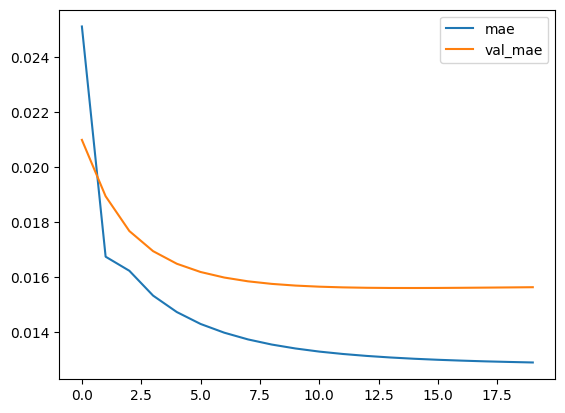

In [15]:
loss_df[['mae', 'val_mae']].plot()

## 9. 

Train an LSTM model and report the Test MAE. Feel free to pick any architecture but you could also use the RNN architecture above.

In [16]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [keras.callbacks.ModelCheckpoint("LSTM.keras", save_best_only=True)]

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 3.0824e-04 - mae: 0.0123 - val_loss: 4.1855e-04 - val_mae: 0.0160
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.8917e-04 - mae: 0.0117 - val_loss: 4.0865e-04 - val_mae: 0.0158
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8882e-04 - mae: 0.0117 - val_loss: 4.0756e-04 - val_mae: 0.0158
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8698e-04 - mae: 0.0116 - val_loss: 4.0966e-04 - val_mae: 0.0158
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8574e-04 - mae: 0.0116 - val_loss: 4.1141e-04 - val_mae: 0.0159
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ -0s -12766us/step - loss: 2.8478e-04 - mae: 0.0116 - val_loss: 4.1310e-04 - val_mae: 0.0159
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8394e-04 - mae: 0.0116 - val_loss: 4.1490e-04 - val_mae: 0.0160
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8327e-04 - mae: 0.0116 - val_loss: 4.1670e-04 - val_mae: 0.

## 10. 

Using the LSTM model, plot the MAE vs epoch for train and validation set.

In [18]:
model_lstm = keras.models.load_model("LSTM.keras")
print(f"Test MAE: {model_lstm.evaluate(test_dataset)[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9266e-04 - mae: 0.0131  
Test MAE: 0.012176582589745522


In [19]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()

,loss,mae,val_loss,val_mae
15,0.000329,0.012321,0.000428,0.016195
16,0.000329,0.012323,0.000429,0.016207
17,0.000329,0.012325,0.000429,0.016216
18,0.000329,0.012327,0.000430,0.016223
19,0.000329,0.012328,0.000430,0.016228


<Axes: >

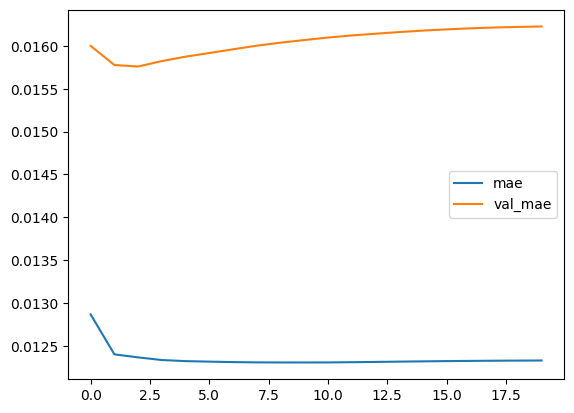

In [20]:
loss_df[['mae', 'val_mae']].plot()

## 11.

Train the following more complex model:

1. Two recurrent layers stacked on top of each other.
    * LSTM with 128 nodes and recurrent_dropout=0.1
    * SimpleRNN with 128 nodes and recurrent_dropout=0.1
    * Dropout(0.1)
2. LSTM with 128 nodes and recurrent_dropout=0.1
3. epochs=20
4. Use loss='mse'
5. Keep track of MAE metric

In [21]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(128, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = layers.SimpleRNN(128, recurrent_dropout=0.1, return_sequences=True)(x)
x = layers.Dropout(0.1)(x)
x = layers.LSTM(128, recurrent_dropout=0.1)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("LSTM2.keras", save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 436ms/step - loss: 0.0165 - mae: 0.0833 - val_loss: 5.1423e-04 - val_mae: 0.0180
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - loss: 7.1672e-04 - mae: 0.0200 - val_loss: 4.2454e-04 - val_mae: 0.0161
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - loss: 4.2210e-04 - mae: 0.0150 - val_loss: 4.1943e-04 - val_mae: 0.0160
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - loss: 3.8139e-04 - mae: 0.0142 - val_loss: 4.0275e-04 - val_mae: 0.0155
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - loss: 3.7928e-04 - mae: 0.0141 - val_loss: 4.0040e-04 - val_mae: 0.0154
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - loss: 3.5929e-04 - mae: 0.0134 - val_loss: 4.0060e-04 - val_mae: 0.0154
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 420ms/step - loss: 3.4274e-04 - mae: 0.0131 - val_loss: 4.0113e-04 - val_mae: 0.0154
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - loss: 3.1903e-04 - mae: 0.0125 - val_loss: 4.1118e-04 - val_

## 12. 

Using the stacked complex model, plot the MAE vs epoch for train and validation set.

<Axes: >

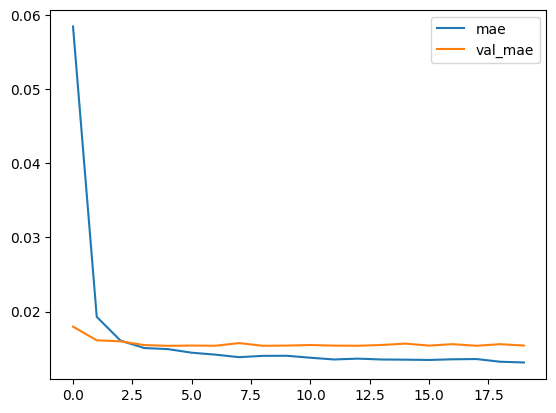

In [22]:
loss_df = pd.DataFrame(history.history)
loss_df[['mae', 'val_mae']].plot()

In [23]:
model_stacked = keras.models.load_model("LSTM2.keras")
print(f"Test MAE: {model_stacked.evaluate(test_dataset)[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 3.0621e-04 - mae: 0.0132
Test MAE: 0.012327890843153


## 13. 

Which model is the winner? Naive, RNN, LSTM, or stacked?

In [24]:
# naive forecast
print(f"Test MAE: {evaluate_naive_method(test_dataset)}") 

# RNN forecast
model_rnn = keras.models.load_model("RNN.keras")
print(f"Test MAE: {model_rnn.evaluate(test_dataset)[1]}")

# lstm forecast
model_lstm = keras.models.load_model("LSTM.keras")
print(f"Test MAE: {model_lstm.evaluate(test_dataset)[1]}")

# stacked lstm forecast
model_stacked = keras.models.load_model("LSTM2.keras")
print(f"Test MAE: {model_stacked.evaluate(test_dataset)[1]}")

Test MAE: 0.01743314097910985


2024-11-26 20:40:31.667985: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.9352e-04 - mae: 0.0132
Test MAE: 0.012238225899636745
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9266e-04 - mae: 0.0131  
Test MAE: 0.012176582589745522
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 3.0621e-04 - mae: 0.0132
Test MAE: 0.012327890843153


The basic LSTM model is slightly winning. 